In [1]:
import os , csv ,multiprocessing , configparser
from tools.import_data import *
from pathlib import Path, PureWindowsPath
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import feature_selection as fs
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer # for NaN values
from pandas import read_csv
import matplotlib.pyplot as plt

In [3]:
def train_the_data(X_train,Y_train,models):
    # Spot Check Algorithms with cross validation
    # evaluate each model in turn
    scoring = 'accuracy'
    scores = []
    names = []
    results = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold,n_jobs=-1, scoring=scoring )
        scores.append(cv_results)
        names.append(name)
        results.append({"name":name,"score":cv_results.mean()})
        # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        # print(msg)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(scores)
    ax.set_xticklabels(names)
    plt.show()
    return results
        
def test_the_data(X_train,Y_train,X_test,Y_test,models):
    # Make predictions on test dataset
    results = []
    for name, model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        # print('Model ' , name)
        # print('Accuracy: ', accuracy_score(Y_test, predictions))
        results.append({"name":name,"score":accuracy_score(Y_test, predictions)})
        #print(confusion_matrix(Y_validation, predictions))
        # print(classification_report(Y_test, predictions))
    return results 
    # 
    # encoder(predict_dataset)
    # #print (predict_dataset)
    # predict=predict_dataset.values[:,0:22]
    # 
    # predictions = lr.predict(predict)
    
    # temp = pandas.DataFrame(predict)
    # temp['class'] = predictions
    # temp.to_csv('predict.csv')
def get_the_best(results): # input - list of dict {"name":name,"score":score}
    m = max([k["score"] for k in results])
    i = [k["score"] for k in results].index(m)
    name = results[i]["name"]
    printmd('The best model for the given data is: <span style="color:green">' + str(name).format() + '</span> with the score <span style="color:green">' + str(m) + '</span>' )
    # print ('The best model for the given train (' + X_train.shape +') is: ' + name + 'with the score ' +m )
    return results[i] # the max model (dict type)

# def information_gain(X, y):
#     def _entropy(labels):
#         counts = np.bincount(labels)
#         return entropy(counts, base=None)
# 
#     def _ig(x, y):
#         # indices where x is set/not set
#         x_set = np.nonzero(x)[1]
#         x_not_set = np.delete(np.arange(x.shape[1]), x_set)
# 
#         h_x_set = _entropy(y[x_set])
#         h_x_not_set = _entropy(y[x_not_set])
# 
#         return entropy_full - (((len(x_set) / f_size) * h_x_set)
#                              + ((len(x_not_set) / f_size) * h_x_not_set))
# 
#     entropy_full = _entropy(y)
# 
#     f_size = float(X.shape[0])
# 
#     scores = np.array([_ig(x, y) for x in X.T])
#     return scores

In [12]:
#consts
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CONFIG_FILE = '{}/config.ini'.format(FILE_PATH)
config = configparser.ConfigParser()
config.read(CONFIG_FILE)
TRAIN_FILE = str(config['files']['train_set'])
TEST_FILE = str(config['files']['test_set'])

models = []
    
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

if __name__ == "__main__":
    X_train, Y_train , original_headers_train = load_dataset(TRAIN_FILE) 
    print ('Train data shape: ', X_train.shape)
    print ('Train labels shape: ', Y_train.shape)
    if TEST_FILE:
        X_test, Y_test ,original_headers_test = load_dataset(TEST_FILE)
        print ('Test data shape: ', X_test.shape)
        print ('Test labels shape: ', Y_test.shape)

(776, 21)
Train data shape:  (776, 21)
Train labels shape:  (776,)


In [13]:
    # Encoding Categorial features and imputing NaN's
    # https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/
    # http://pbpython.com/categorical-encoding.html
    # https://datascience.stackexchange.com/questions/14069/mass-convert-categorical-columns-in-pandas-not-one-hot-encoding
    char_cols = X_train.dtypes.pipe(lambda x: x[x == 'object']).index
    if not char_cols.empty:
        label_mapping = {}
        for c in char_cols:
            X_train_non_numeric = X_train.copy()
            X_train[c], label_mapping[c] = pd.factorize(X_train[c])
    imp = Imputer(axis=0, verbose=1)
    imp = imp.fit(X_train)
    X_train_imp = imp.transform(X_train)
    print ('New Train data shape: ',X_train_imp.shape)
    fs_scores = fs.mutual_info_classif(X_train_imp,Y_train)
    for i,score in enumerate(fs_scores):
        print ('{}|{}'.format(original_headers_train[i],score))

New Train data shape:  (776, 21)
AGE|0.008332659329502778
SEX|0.07344221026527964
HEIGHT|0.06490955425883316
WEIGHT|0.03668202722932623
WAIST_CIRCUMFERENCE|0.08900415111700077
EDUCATION_LEVEL|0.011949609034282771
SMK_EVER_SMOKED|0.025068870429183043
SMK_AGE_STARTED|0.008619909456568209
SMK_AGE_SMOKING_STOPPED|0.04827754171504961
ALC_UNITS_PER_WEEK|0.03212570962906236
ALC_UNITS_PER_WEEK_AGED_30|0.039137990452766
ALC_DRINK_HEAVILY|0.011525896094562782
PREFERRED_DRINK|0.029239676235640166
SYM_CHEST_PAIN|0.06321354790869993
SYM_BURNING_CHEST|0.0498348462380922
SYM_ACID_TASTE|0.004018513084999897
SYM_SORE_THROAT|0.01515704448830446
SYM_SLEEP_DISRUPTED|0.040008425239727474
SYM_YRS_SINCE_HEARTBURN_START|0.1488346478015672
SYM_YRS_SINCE_ACID_TASTE_START|0.1258500439845509
SYM_TAKING_STOMACH_MEDS|0.07521696319531479


In [14]:
    #before we found the elbow
    new_trains = []
    new_shapes_ratio = []
    new_range = []
    myrange = np.arange(0.01, 1, 0.01)
    for VTHRESH in myrange:  
        # sel = fs.VarianceThreshold(VTHRESH)
        sel = fs.SelectPercentile(score_func=fs.mutual_info_classif,percentile=VTHRESH*100)
        # sel.fit(X_train_imp,Y_train)
        # print (sel.get_params())
        # print (sel.get_support())
        X_train_mod = sel.fit_transform(X_train_imp,Y_train)
        if len(new_shapes_ratio) >= 1:
            if new_shapes_ratio[-1]!= X_train_mod.shape[-1]/X_train.shape[-1]:
                new_range.append(VTHRESH)
                new_trains.append(X_train_mod)
                new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
        else:
            new_range.append(VTHRESH)
            new_trains.append(X_train_mod)
            new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
        


**Training Section** for: 1 features

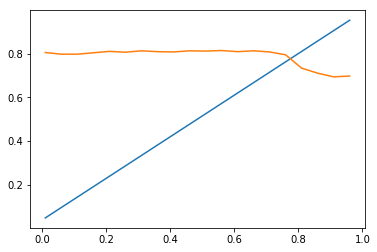

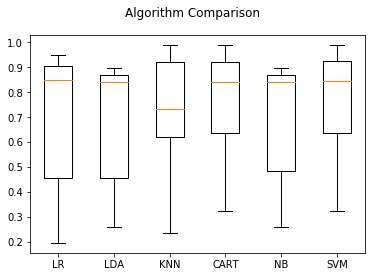

The best model for the given data is: <span style="color:green">SVM</span> with the score <span style="color:green">0.757925407925</span>

{'name': 'LR', 'score': 0.69695304695304694}
{'name': 'LDA', 'score': 0.68934398934398933}
{'name': 'KNN', 'score': 0.70767565767565777}
{'name': 'CART', 'score': 0.75406260406260417}
{'name': 'NB', 'score': 0.69843489843489848}
{'name': 'SVM', 'score': 0.75792540792540797}


**Training Section** for: 2 features

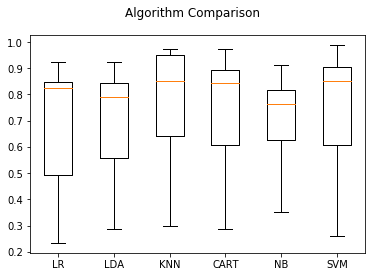

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.764219114219</span>

{'name': 'LR', 'score': 0.69335664335664338}
{'name': 'LDA', 'score': 0.70258075258075259}
{'name': 'KNN', 'score': 0.76421911421911415}
{'name': 'CART', 'score': 0.7475191475191475}
{'name': 'NB', 'score': 0.70281385281385289}
{'name': 'SVM', 'score': 0.7475191475191475}


**Training Section** for: 3 features

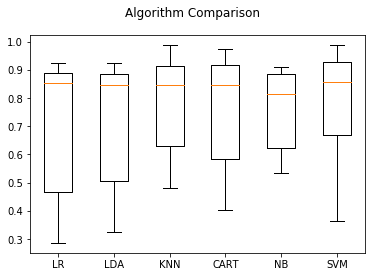

The best model for the given data is: <span style="color:green">KNN</span> with the score <span style="color:green">0.777522477522</span>

{'name': 'LR', 'score': 0.71010656010656015}
{'name': 'LDA', 'score': 0.72049617049617054}
{'name': 'KNN', 'score': 0.77752247752247738}
{'name': 'CART', 'score': 0.75922410922410921}
{'name': 'NB', 'score': 0.76225441225441215}
{'name': 'SVM', 'score': 0.77216117216117208}


**Training Section** for: 4 features

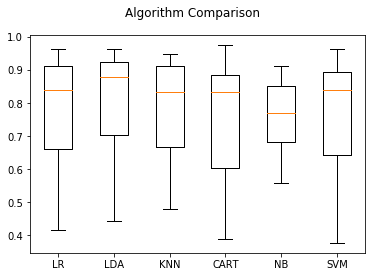

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.795604395604</span>

{'name': 'LR', 'score': 0.76595071595071595}
{'name': 'LDA', 'score': 0.79560439560439566}
{'name': 'KNN', 'score': 0.7814352314352313}
{'name': 'CART', 'score': 0.74908424908424898}
{'name': 'NB', 'score': 0.76122211122211125}
{'name': 'SVM', 'score': 0.75422910422910427}


**Training Section** for: 5 features

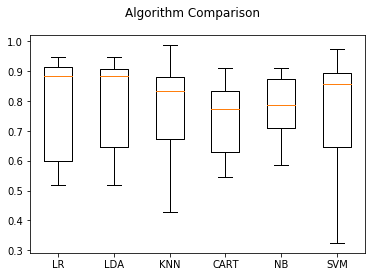

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.798118548119</span>

{'name': 'LR', 'score': 0.78779553779553779}
{'name': 'LDA', 'score': 0.7981185481185481}
{'name': 'KNN', 'score': 0.76198801198801192}
{'name': 'CART', 'score': 0.74164169164169158}
{'name': 'NB', 'score': 0.78183483183483171}
{'name': 'SVM', 'score': 0.74761904761904763}


**Training Section** for: 6 features

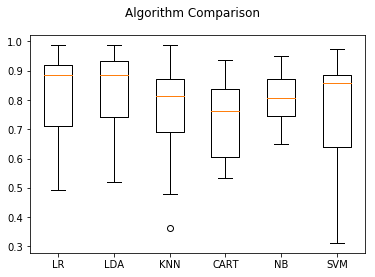

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.822743922744</span>

{'name': 'LR', 'score': 0.8111055611055612}
{'name': 'LDA', 'score': 0.82274392274392272}
{'name': 'KNN', 'score': 0.74910089910089905}
{'name': 'CART', 'score': 0.73651348651348658}
{'name': 'NB', 'score': 0.80907425907425901}
{'name': 'SVM', 'score': 0.74109224109224114}


**Training Section** for: 7 features

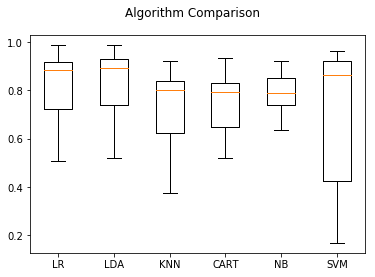

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.824025974026</span>

{'name': 'LR', 'score': 0.8163003663003664}
{'name': 'LDA', 'score': 0.824025974025974}
{'name': 'KNN', 'score': 0.72459207459207453}
{'name': 'CART', 'score': 0.74811854811854805}
{'name': 'NB', 'score': 0.78984348984348984}
{'name': 'SVM', 'score': 0.69808524808524797}


**Training Section** for: 8 features

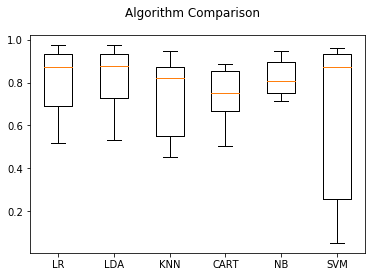

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.820729270729</span>

{'name': 'LR', 'score': 0.81243756243756238}
{'name': 'LDA', 'score': 0.81891441891441885}
{'name': 'KNN', 'score': 0.74124209124209117}
{'name': 'CART', 'score': 0.73654678654678662}
{'name': 'NB', 'score': 0.82072927072927082}
{'name': 'SVM', 'score': 0.64998334998334995}


**Training Section** for: 9 features

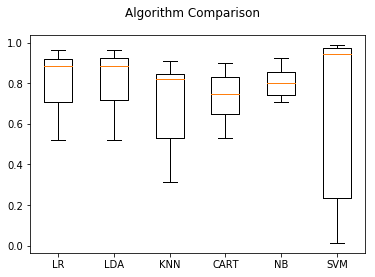

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.817632367632</span>

{'name': 'LR', 'score': 0.81506826506826502}
{'name': 'LDA', 'score': 0.81763236763236757}
{'name': 'KNN', 'score': 0.69988344988344986}
{'name': 'CART', 'score': 0.73140193140193144}
{'name': 'NB', 'score': 0.80276390276390275}
{'name': 'SVM', 'score': 0.66909756909756912}


**Training Section** for: 10 features

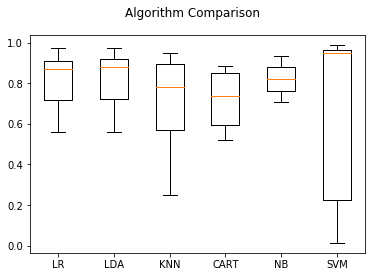

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.820263070263</span>

{'name': 'LR', 'score': 0.8150849150849151}
{'name': 'LDA', 'score': 0.8202630702630701}
{'name': 'KNN', 'score': 0.71010656010656015}
{'name': 'CART', 'score': 0.72234432234432244}
{'name': 'NB', 'score': 0.81823176823176824}
{'name': 'SVM', 'score': 0.66262071262071265}


**Training Section** for: 11 features

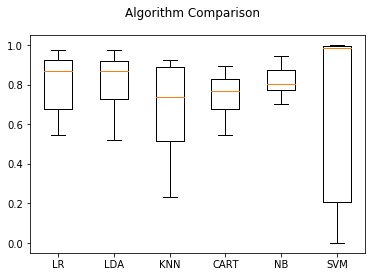

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.820795870796</span>

{'name': 'LR', 'score': 0.80857475857475847}
{'name': 'LDA', 'score': 0.81375291375291392}
{'name': 'KNN', 'score': 0.67783882783882787}
{'name': 'CART', 'score': 0.74958374958374951}
{'name': 'NB', 'score': 0.8207958707958708}
{'name': 'SVM', 'score': 0.67537462537462534}


**Training Section** for: 12 features

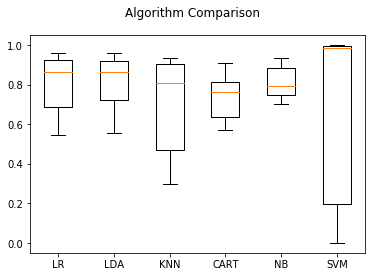

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.8164002664</span>

{'name': 'LR', 'score': 0.81250416250416246}
{'name': 'LDA', 'score': 0.81640026640026642}
{'name': 'KNN', 'score': 0.70093240093240095}
{'name': 'CART', 'score': 0.74302364302364299}
{'name': 'NB', 'score': 0.81561771561771557}
{'name': 'SVM', 'score': 0.67407592407592409}


**Training Section** for: 13 features

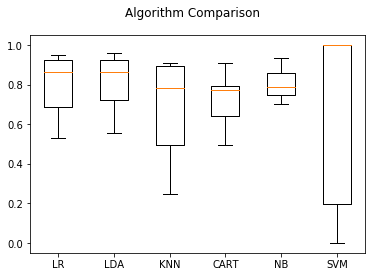

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.817682317682</span>

{'name': 'LR', 'score': 0.80730935730935727}
{'name': 'LDA', 'score': 0.81768231768231769}
{'name': 'KNN', 'score': 0.68809523809523809}
{'name': 'CART', 'score': 0.73391608391608387}
{'name': 'NB', 'score': 0.80276390276390275}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 14 features

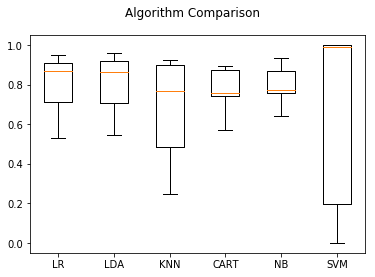

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.80994005994</span>

{'name': 'LR', 'score': 0.80474525474525493}
{'name': 'LDA', 'score': 0.80994005994005991}
{'name': 'KNN', 'score': 0.68681318681318682}
{'name': 'CART', 'score': 0.77151182151182152}
{'name': 'NB', 'score': 0.80283050283050295}
{'name': 'SVM', 'score': 0.67664002664002665}


**Training Section** for: 15 features

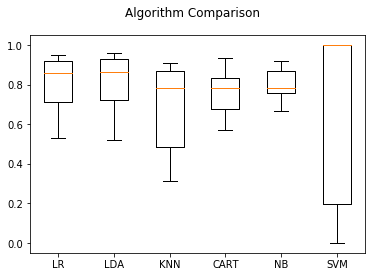

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.812520812521</span>

{'name': 'LR', 'score': 0.80476190476190479}
{'name': 'LDA', 'score': 0.81252081252081254}
{'name': 'KNN', 'score': 0.6894771894771895}
{'name': 'CART', 'score': 0.75980685980685969}
{'name': 'NB', 'score': 0.80281385281385265}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 16 features

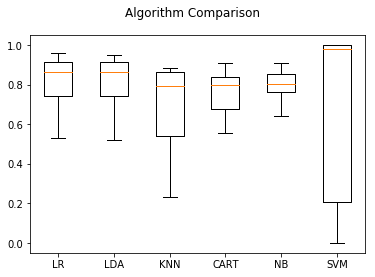

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.811255411255</span>

{'name': 'LR', 'score': 0.81125541125541134}
{'name': 'LDA', 'score': 0.80870795870795875}
{'name': 'KNN', 'score': 0.68954378954378959}
{'name': 'CART', 'score': 0.76618381618381615}
{'name': 'NB', 'score': 0.80154845154845145}
{'name': 'SVM', 'score': 0.67667332667332669}


**Training Section** for: 17 features

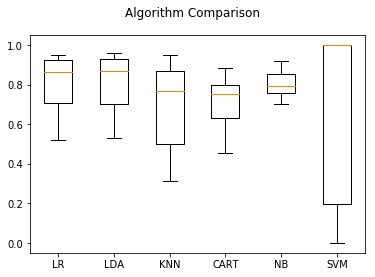

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.813786213786</span>

{'name': 'LR', 'score': 0.80990675990675987}
{'name': 'LDA', 'score': 0.81378621378621374}
{'name': 'KNN', 'score': 0.69079254079254071}
{'name': 'CART', 'score': 0.71968031968031965}
{'name': 'NB', 'score': 0.8040626040626041}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 18 features

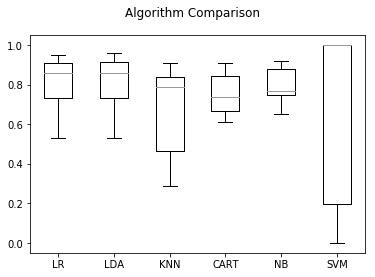

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.809956709957</span>

{'name': 'LR', 'score': 0.80477855477855476}
{'name': 'LDA', 'score': 0.80995670995670999}
{'name': 'KNN', 'score': 0.67142857142857149}
{'name': 'CART', 'score': 0.75214785214785207}
{'name': 'NB', 'score': 0.79890109890109895}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 19 features

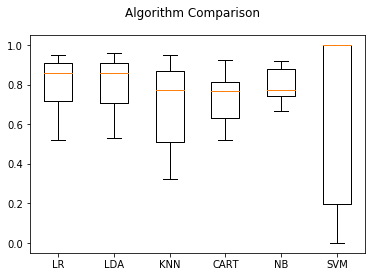

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.807392607393</span>

{'name': 'LR', 'score': 0.79960039960039953}
{'name': 'LDA', 'score': 0.80739260739260743}
{'name': 'KNN', 'score': 0.69595404595404597}
{'name': 'CART', 'score': 0.7403096903096904}
{'name': 'NB', 'score': 0.79890109890109895}
{'name': 'SVM', 'score': 0.67792207792207793}


**Training Section** for: 20 features

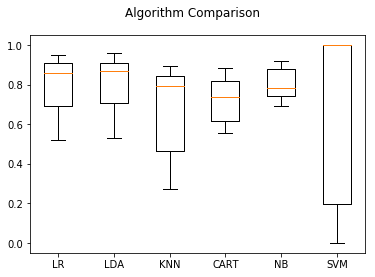

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.806060606061</span>

{'name': 'LR', 'score': 0.79828504828504832}
{'name': 'LDA', 'score': 0.80606060606060626}
{'name': 'KNN', 'score': 0.67787212787212781}
{'name': 'CART', 'score': 0.72885447885447885}
{'name': 'NB', 'score': 0.80401265401265398}
{'name': 'SVM', 'score': 0.67792207792207793}


In [15]:
    best_tr_results = []
    # new_trains.reverse()
    for X_train_mod in new_trains:
        # train the new shape
        printmd("**Training Section** for: " + str(X_train_mod.shape[-1]) + " features")
        train_resultes = train_the_data(X_train_mod,Y_train,models)
        best_tr = get_the_best(train_resultes)
        best_tr_results.append({"name":best_tr['name'],"score":best_tr['score'],"num_fetures":int(X_train_mod.shape[-1])})
        for model in train_resultes:
            print (model)

In [16]:
    for best in best_tr_results:
        print(best)
    plt.plot(new_range, np.column_stack((new_shapes_ratio, [rs['score'] for rs in best_tr_results])))

{'name': 'SVM', 'score': 0.75792540792540797, 'num_fetures': 1}
{'name': 'KNN', 'score': 0.76421911421911415, 'num_fetures': 2}
{'name': 'KNN', 'score': 0.77752247752247738, 'num_fetures': 3}
{'name': 'LDA', 'score': 0.79560439560439566, 'num_fetures': 4}
{'name': 'LDA', 'score': 0.7981185481185481, 'num_fetures': 5}
{'name': 'LDA', 'score': 0.82274392274392272, 'num_fetures': 6}
{'name': 'LDA', 'score': 0.824025974025974, 'num_fetures': 7}
{'name': 'NB', 'score': 0.82072927072927082, 'num_fetures': 8}
{'name': 'LDA', 'score': 0.81763236763236757, 'num_fetures': 9}
{'name': 'LDA', 'score': 0.8202630702630701, 'num_fetures': 10}
{'name': 'NB', 'score': 0.8207958707958708, 'num_fetures': 11}
{'name': 'LDA', 'score': 0.81640026640026642, 'num_fetures': 12}
{'name': 'LDA', 'score': 0.81768231768231769, 'num_fetures': 13}
{'name': 'LDA', 'score': 0.80994005994005991, 'num_fetures': 14}
{'name': 'LDA', 'score': 0.81252081252081254, 'num_fetures': 15}
{'name': 'LR', 'score': 0.811255411255411

**Training Section** for: 418976 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


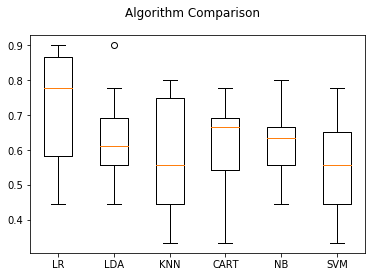

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7144444444444444</span>

{'name': 'LR', 'score': 0.7144444444444444}
{'name': 'LDA', 'score': 0.6266666666666667}
{'name': 'KNN', 'score': 0.5822222222222223}
{'name': 'CART', 'score': 0.62}
{'name': 'NB', 'score': 0.6177777777777778}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 300021 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


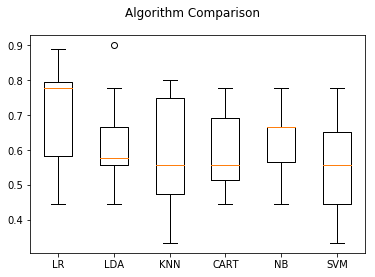

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6933333333333334</span>

{'name': 'LR', 'score': 0.6933333333333334}
{'name': 'LDA', 'score': 0.6166666666666666}
{'name': 'KNN', 'score': 0.5822222222222222}
{'name': 'CART', 'score': 0.5977777777777777}
{'name': 'NB', 'score': 0.6211111111111112}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 249789 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


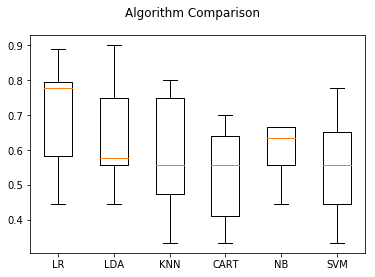

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6933333333333334</span>

{'name': 'LR', 'score': 0.6933333333333334}
{'name': 'LDA', 'score': 0.6277777777777778}
{'name': 'KNN', 'score': 0.5933333333333334}
{'name': 'CART', 'score': 0.5211111111111111}
{'name': 'NB', 'score': 0.598888888888889}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 212518 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


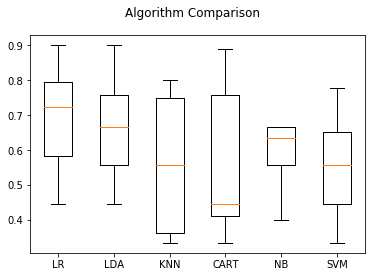

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6922222222222223</span>

{'name': 'LR', 'score': 0.6922222222222223}
{'name': 'LDA', 'score': 0.6488888888888888}
{'name': 'KNN', 'score': 0.56}
{'name': 'CART', 'score': 0.5544444444444444}
{'name': 'NB', 'score': 0.5888888888888889}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 181350 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


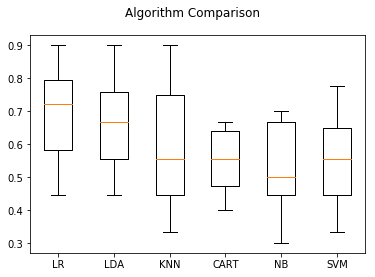

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6488888888888888}
{'name': 'KNN', 'score': 0.5811111111111111}
{'name': 'CART', 'score': 0.5466666666666666}
{'name': 'NB', 'score': 0.5333333333333334}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 153725 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


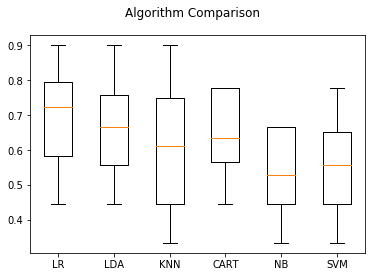

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6599999999999999}
{'name': 'KNN', 'score': 0.5922222222222222}
{'name': 'CART', 'score': 0.6533333333333333}
{'name': 'NB', 'score': 0.5344444444444444}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 129439 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


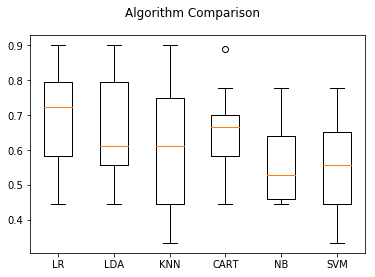

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6588888888888889}
{'name': 'KNN', 'score': 0.5922222222222222}
{'name': 'CART', 'score': 0.6622222222222222}
{'name': 'NB', 'score': 0.5555555555555556}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 108368 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


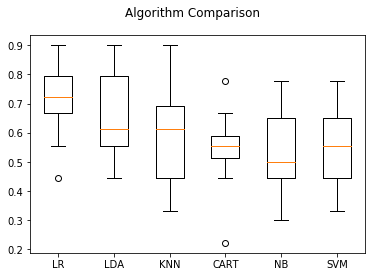

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7144444444444445</span>

{'name': 'LR', 'score': 0.7144444444444445}
{'name': 'LDA', 'score': 0.6588888888888889}
{'name': 'KNN', 'score': 0.5822222222222223}
{'name': 'CART', 'score': 0.5433333333333333}
{'name': 'NB', 'score': 0.5344444444444445}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 90282 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [ ]:
#need to modify the test shape
    printmd("**Testing Section:**")
    test_results = test_the_data(X_train,Y_train,X_test,Y_test,models)
    best_ts = get_the_best(test_results)
    for model in test_results:
        print (model)


In [9]:
    # #after we found the elbow
    # new_shape = []
    # range = np.arange(0.04, 0.17, 0.001)
    # for VTHRESH in range:  
    #     sel = fs.VarianceThreshold(VTHRESH)
    #     x = sel.fit_transform(X_train)
    #     new_shape.append(x.shape[-1])
    # plt.plot(range, new_shape)